In [239]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import networkx as nx
import seaborn as sns

In [241]:
df = pd.read_csv('Data PB Up to 31 August 2024 (with product detail).csv', encoding='ISO-8859-1')
print(df.head())
print(df.columns)

              COMPANY_DESC CHANNEL_STATUS SOURCE_STATUS  MARKETPLACE_NAME  \
0  PT ERA BOGA PATISERINDO        OFFLINE        WALKIN               NaN   
1  PT ERA BOGA PATISERINDO        OFFLINE        WALKIN               NaN   
2  PT ERA BOGA PATISERINDO        OFFLINE        WALKIN               NaN   
3  PT ERA BOGA PATISERINDO        OFFLINE        WALKIN               NaN   
4  PT ERA BOGA PATISERINDO        OFFLINE        WALKIN               NaN   

  STORE_CODE          STORE_NAME ORDER_DATE ORDER_TIME        ORDER_NUMBER  \
0       PB09  PARIS BAGUETTE PIK    8/27/23   15:31:33  SPBPIK169312507967   
1       PB09  PARIS BAGUETTE PIK    12/3/22   12:40:27  SPBPIK167004598796   
2       PB09  PARIS BAGUETTE PIK    6/18/24   15:54:19  SPBPIK171870084769   
3       PB09  PARIS BAGUETTE PIK     1/4/24   12:22:17  SPBPIK170434567729   
4       PB09  PARIS BAGUETTE PIK    7/24/24   18:32:08  SPBPIK172182071842   

  EMAIL  ...                     ITEM_NAME NETT_AMOUNT QUANTITY     

In [242]:
df = df.dropna(subset=['VERTICAL'])
df = df.drop(columns=['REGISTER_DATE', 'MARKETPLACE_NAME', 'EMAIL', 'CUSTOMER_ID'])
print(df.isna().sum())

COMPANY_DESC      0
CHANNEL_STATUS    0
SOURCE_STATUS     0
STORE_CODE        0
STORE_NAME        2
ORDER_DATE        0
ORDER_TIME        0
ORDER_NUMBER      0
MEMBER_TYPE       0
ITEM_CODE         0
ITEM_NAME         0
NETT_AMOUNT       0
QUANTITY          0
TIER              0
VERTICAL          0
SUB_VERTICAL      0
ITEM_CATEGORY     0
ITEM_GROUP        0
ITEM_TYPE         0
dtype: int64


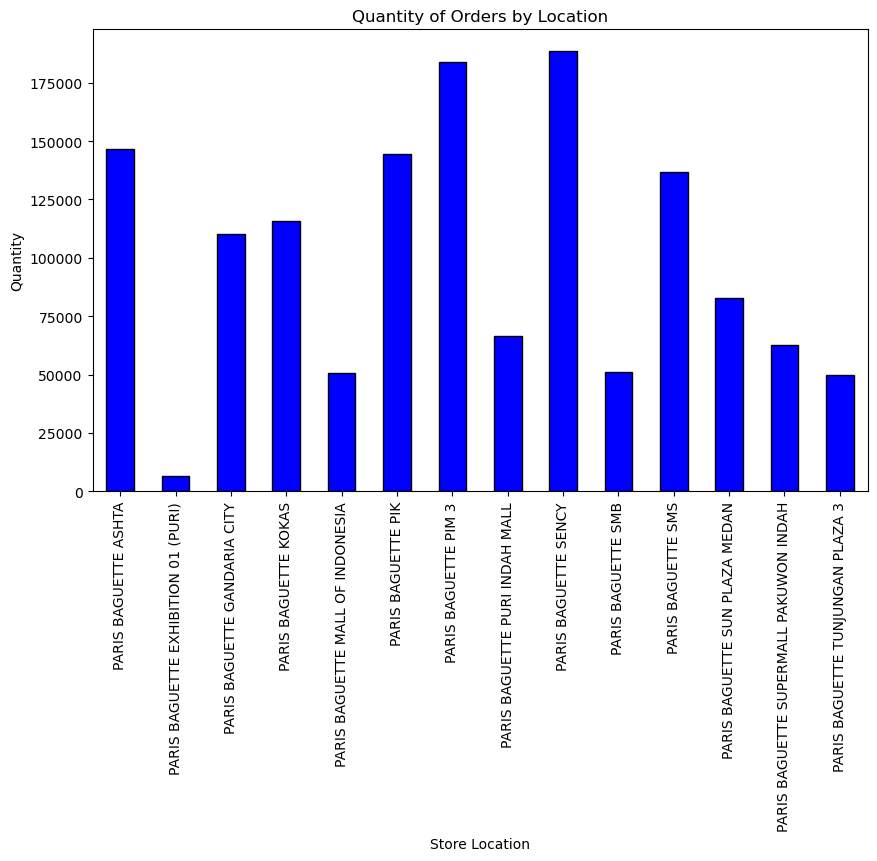

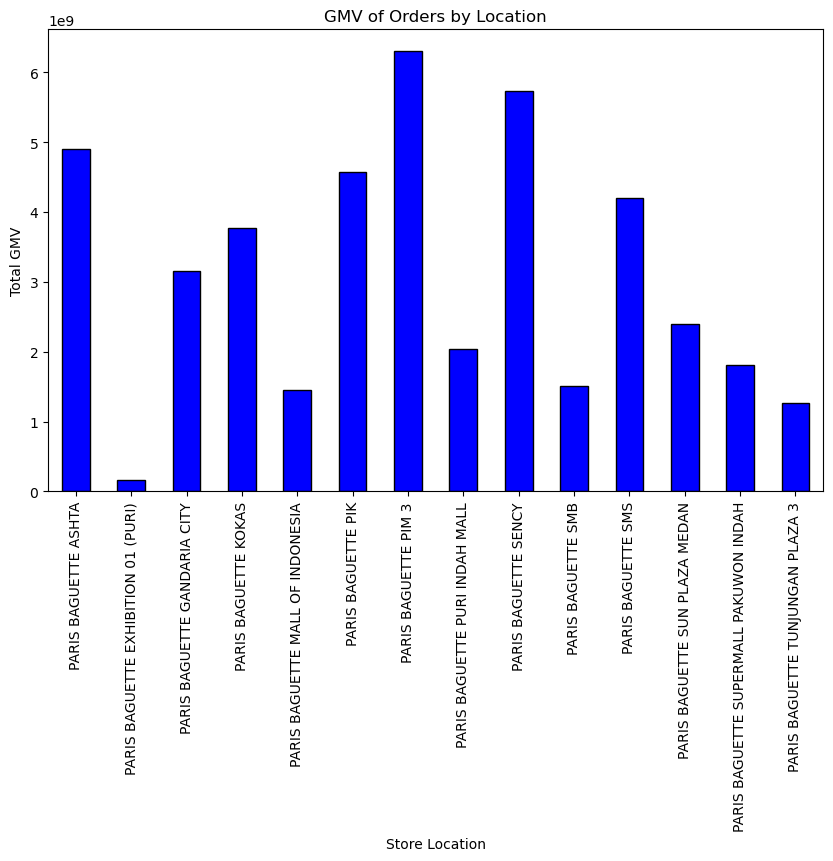

In [243]:
#Gauge location popularity and variance in spending power by location
location_quantity = df.groupby('STORE_NAME')['QUANTITY'].sum()

plt.figure(figsize=(10,6))
location_quantity.plot(kind='bar', color='blue', edgecolor='black')
plt.xlabel('Store Location')
plt.ylabel('Quantity')
plt.title('Quantity of Orders by Location')
plt.xticks(rotation=90)
plt.show()

location_GMV = df.groupby('STORE_NAME')['NETT_AMOUNT'].sum()

plt.figure(figsize=(10,6))
location_GMV.plot(kind='bar', color='blue', edgecolor='black')
plt.xlabel('Store Location')
plt.ylabel('Total GMV')
plt.title('GMV of Orders by Location')
plt.xticks(rotation=90)
plt.show()

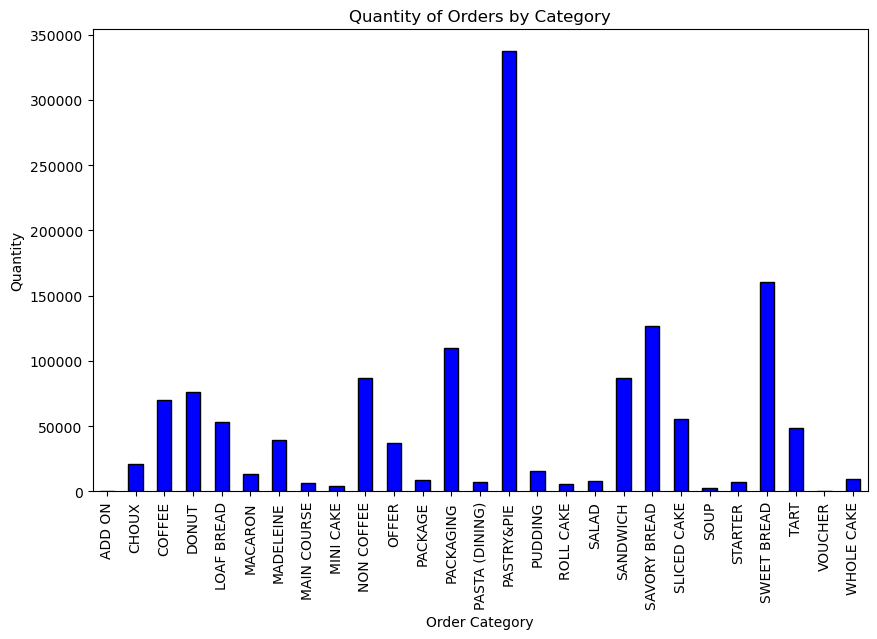

In [244]:
#Gauge item popularity
Item_category = df.groupby('ITEM_GROUP')['QUANTITY'].sum()

plt.figure(figsize=(10,6))
Item_category.plot(kind='bar', color='blue', edgecolor='black')
plt.xlabel('Order Category')
plt.ylabel('Quantity')
plt.title('Quantity of Orders by Category')
plt.xticks(rotation=90)
plt.show()

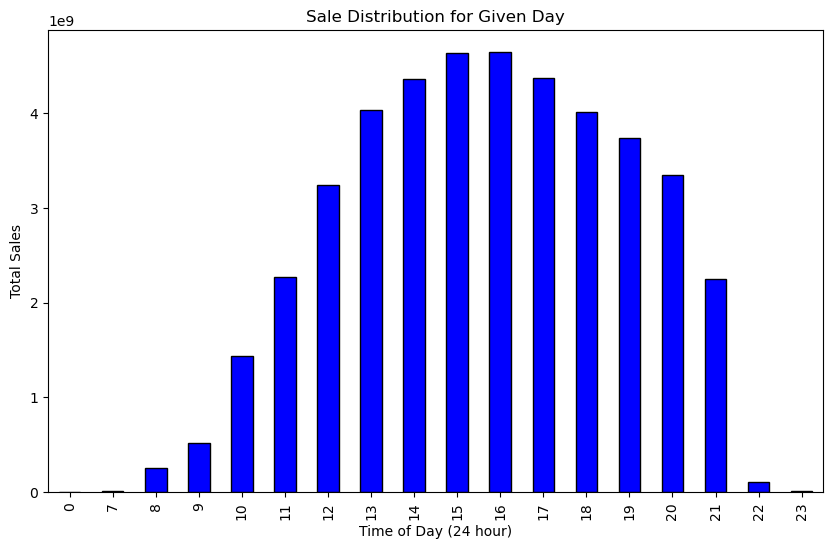

In [245]:
#time series analysis of orders
df['ORDER_HOUR'] = pd.to_datetime(df['ORDER_TIME'], format='%H:%M:%S')
df['ORDER_HOUR'] = df['ORDER_HOUR'].dt.hour

Time_Sales = df.groupby('ORDER_HOUR')['NETT_AMOUNT'].sum()

plt.figure(figsize=(10,6))
Time_Sales.plot(kind='bar', color='blue', edgecolor='black')
plt.xlabel('Time of Day (24 hour)')
plt.ylabel('Total Sales')
plt.title('Sale Distribution for Given Day')
plt.xticks(rotation=90)
plt.show()

/var/folders/p4/0qyllg6d5lxf0bt1rr7rfrx4rh2ztf/T/ipykernel_30866/3677485877.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'])


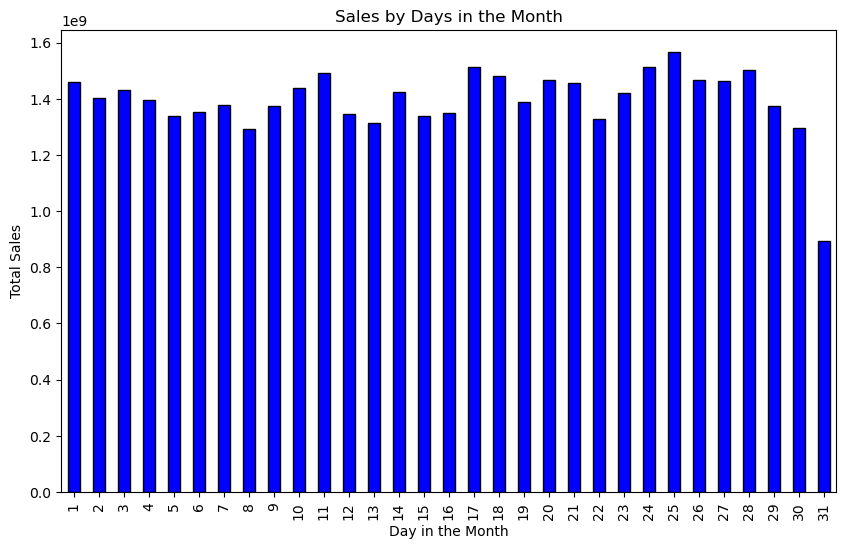

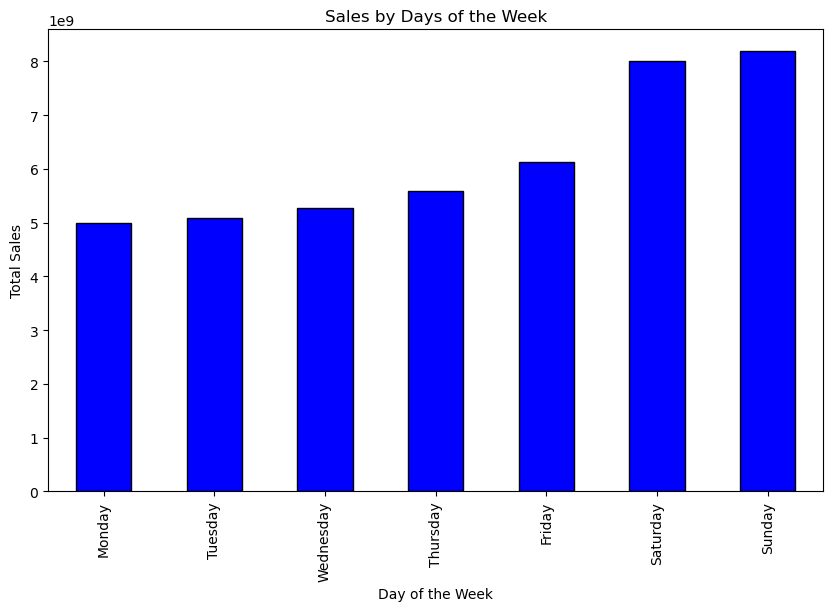

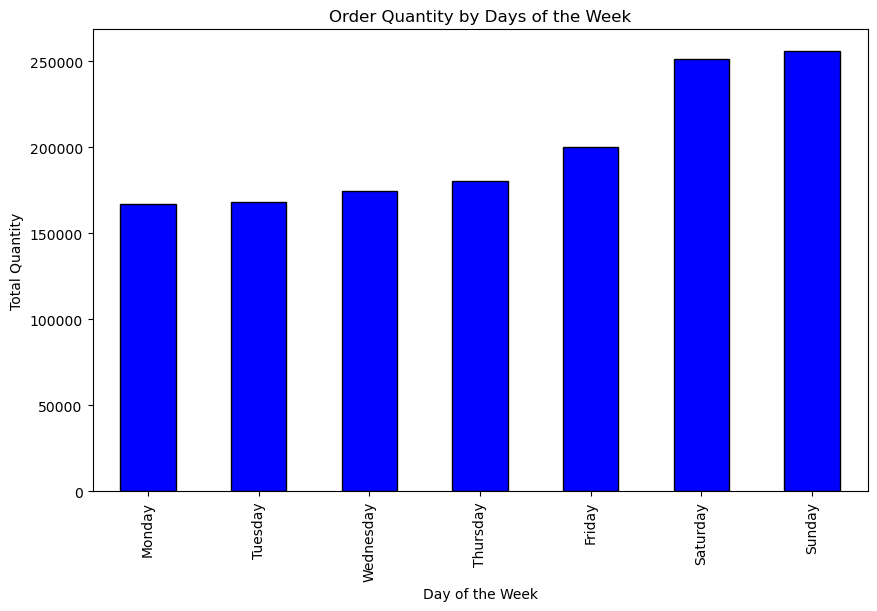

In [246]:
df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'])
df['ORDER_DAY'] = df['ORDER_DATE'].dt.day

Time_Sales = df.groupby('ORDER_DAY')['NETT_AMOUNT'].sum()

plt.figure(figsize=(10,6))
Time_Sales.plot(kind='bar', color='blue', edgecolor='black')
plt.xlabel('Day in the Month')
plt.ylabel('Total Sales')
plt.title('Sales by Days in the Month')
plt.xticks(rotation=90)
plt.show()

df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'])
df['ORDER_DAY_NAME'] = df['ORDER_DATE'].dt.day_name()

Time_Sales = df.groupby('ORDER_DAY_NAME')['NETT_AMOUNT'].sum()
days_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
Time_Sales.index = pd.Categorical(Time_Sales.index, categories=days_of_week_order, ordered=True)
Time_Sales = Time_Sales.sort_index()

plt.figure(figsize=(10,6))
Time_Sales.plot(kind='bar', color='blue', edgecolor='black')
plt.xlabel('Day of the Week')
plt.ylabel('Total Sales')
plt.title('Sales by Days of the Week')
plt.xticks(rotation=90)
plt.show()


df['ORDER_DATE'] = pd.to_datetime(df['ORDER_DATE'])
df['ORDER_DAY_NAME'] = df['ORDER_DATE'].dt.day_name()

Time_QTY = df.groupby('ORDER_DAY_NAME')['QUANTITY'].sum()
days_of_week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
Time_QTY.index = pd.Categorical(Time_QTY.index, categories=days_of_week_order, ordered=True)
Time_QTY = Time_QTY.sort_index()

plt.figure(figsize=(10,6))
Time_QTY.plot(kind='bar', color='blue', edgecolor='black')
plt.xlabel('Day of the Week')
plt.ylabel('Total Quantity')
plt.title('Order Quantity by Days of the Week')
plt.xticks(rotation=90)
plt.show()

In [247]:
def find_outliers(df, multiplier=1.5):
    outliers = {}
    outliers_count = {}

    for column in df.select_dtypes(include=['number']).columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - multiplier * IQR
        upper_bound = Q3 + multiplier * IQR
        outliers_removed = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
        outliers_found = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        print('low bound: ', lower_bound)
        lower_percentile = (df[column] <= lower_bound).mean() * 100
        upper_percentile = (df[column] <= upper_bound).mean() * 100

        
    return outliers_removed, outliers_found, lower_percentile, upper_percentile

cleaned_data, outliers_df, lower_percentile, upper_percentile = find_outliers(df, multiplier=1.5)

print("Original data:", df.shape[0])
print("Outliers Data:", outliers_df.shape[0])
print("Outliers Data Summary Statistics:", outliers_df.describe())
print(cleaned_data.head())


print(f"Lower Bound Percentile: {lower_percentile:.2f}%")
print(f"Upper Bound Percentile: {upper_percentile:.2f}%")

low bound:  -19500.0
low bound:  1.0
low bound:  6.5
low bound:  -16.0
Original data: 1048570
Outliers Data: 0
Outliers Data Summary Statistics:       ORDER_DATE  NETT_AMOUNT  QUANTITY  ORDER_HOUR  ORDER_DAY
count          0          0.0       0.0         0.0        0.0
mean         NaT          NaN       NaN         NaN        NaN
min          NaT          NaN       NaN         NaN        NaN
25%          NaT          NaN       NaN         NaN        NaN
50%          NaT          NaN       NaN         NaN        NaN
75%          NaT          NaN       NaN         NaN        NaN
max          NaT          NaN       NaN         NaN        NaN
std          NaN          NaN       NaN         NaN        NaN
              COMPANY_DESC CHANNEL_STATUS SOURCE_STATUS STORE_CODE  \
0  PT ERA BOGA PATISERINDO        OFFLINE        WALKIN       PB09   
1  PT ERA BOGA PATISERINDO        OFFLINE        WALKIN       PB09   
2  PT ERA BOGA PATISERINDO        OFFLINE        WALKIN       PB09   
3  PT ER

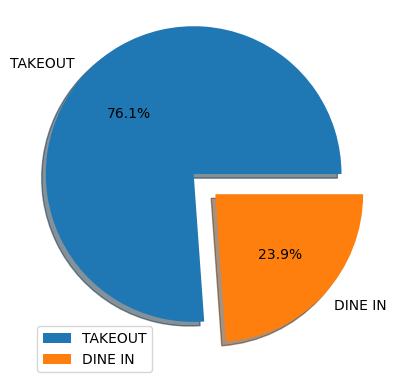

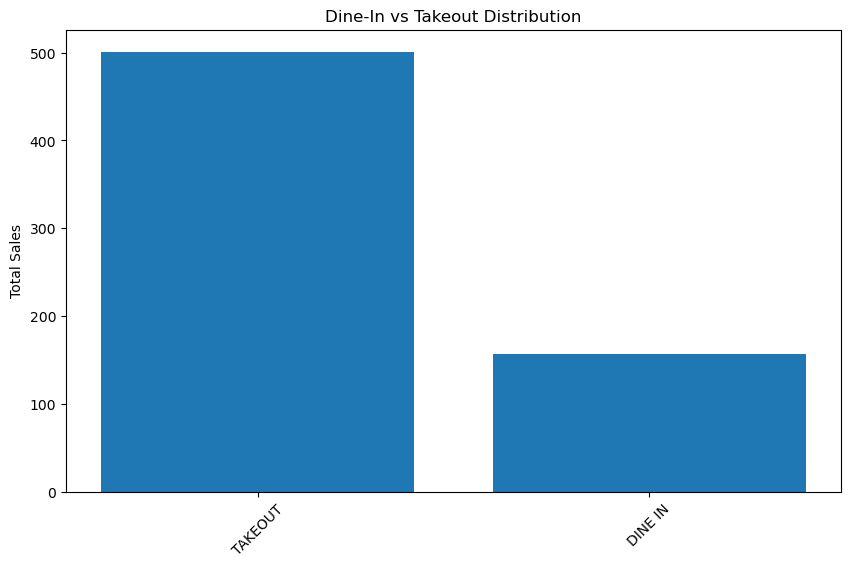

In [248]:
#Data Grouping
dine_in = df[~df['SUB_VERTICAL'].isin(["PACKAGING", "OFFER", "VOUCHER"])]


dine_in = dine_in.groupby('NETT_AMOUNT').first()
dine_in_size = dine_in['SUB_VERTICAL'].value_counts()

dine_in_size
myexplode= [0.2, 0]
fig, ax = plt.subplots()
ax.pie(dine_in_size, labels=dine_in_size.index, explode=myexplode, autopct='%1.1f%%', shadow=True)
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(dine_in_size.index, dine_in_size)
plt.ylabel('Total Sales')
plt.title('Dine-In vs Takeout Distribution')
plt.xticks(rotation=45)
plt.show()

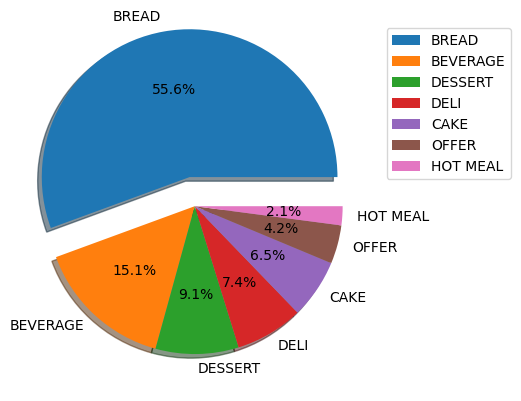

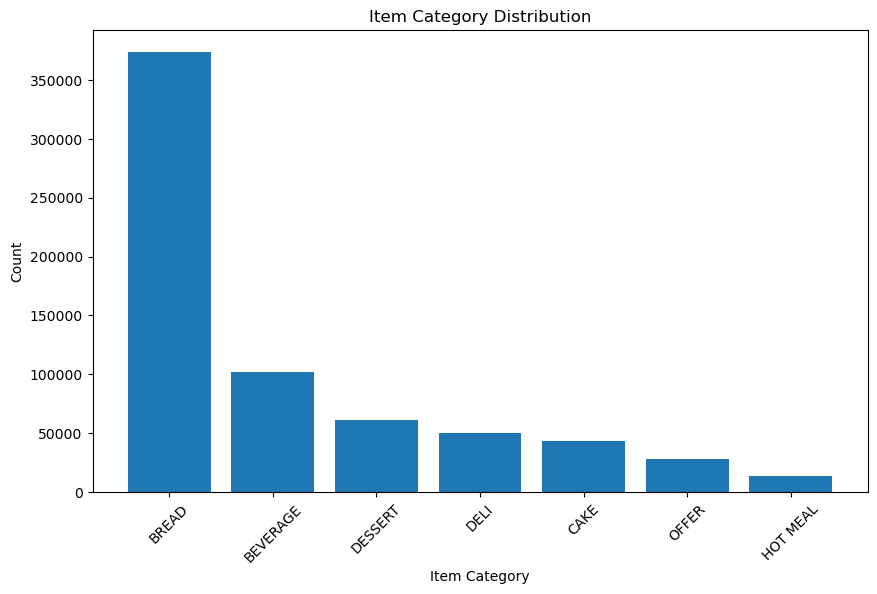

In [249]:
category_distribution = df[~df['ITEM_CATEGORY'].isin(["PACKAGING","ADD ON","PACKAGE", "VOUCHER"])]
category_distribution_transactions = category_distribution.groupby('ORDER_NUMBER').first()
category_distribution_size = category_distribution_transactions['ITEM_CATEGORY'].value_counts()

category_distribution_size
# item_category_size
myexplode= [0.2, 0, 0, 0, 0, 0, 0]
fig, ax = plt.subplots()
ax.pie(category_distribution_size, labels=category_distribution_size.index, explode=myexplode, autopct='%1.1f%%', shadow=True)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(category_distribution_size.index, category_distribution_size)
plt.xlabel('Item Category')
plt.ylabel('Count')
plt.title('Item Category Distribution')
plt.xticks(rotation=45)
plt.show()

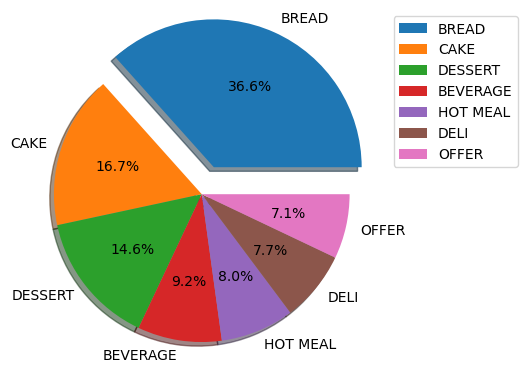

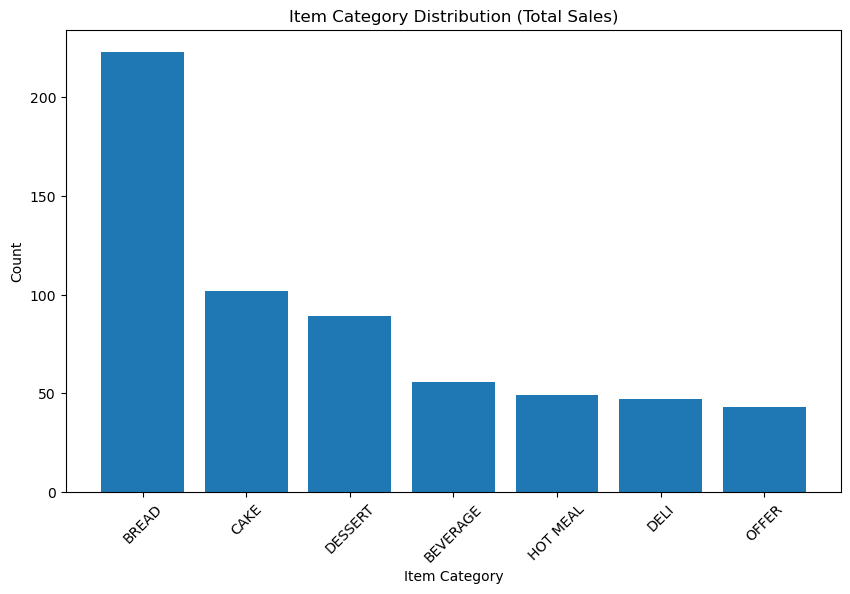

In [261]:
# category_distribution = df[~df['ext_item_category'].isin(["PACKAGING","ADD ON","PACKAGE"])]
category_distribution_sales = category_distribution.groupby('NETT_AMOUNT').first()
category_distribution_sales_size = category_distribution_sales['ITEM_CATEGORY'].value_counts()

# item_category_size
myexplode= [0.2, 0, 0, 0, 0, 0, 0]
fig, ax = plt.subplots()
ax.pie(category_distribution_sales_size, labels=category_distribution_sales_size.index, explode=myexplode, autopct='%1.1f%%', shadow=True)
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.show()

plt.figure(figsize=(10, 6))
plt.bar(category_distribution_sales_size.index, category_distribution_sales_size)
plt.xlabel('Item Category')
plt.ylabel('Count')
plt.title('Item Category Distribution (Total Sales)')
plt.xticks(rotation=45)
plt.show()

In [327]:
print(df['ITEM_CATEGORY'].unique())
print(df['ITEM_GROUP'].unique())
group_sales = df.groupby('ITEM_GROUP')['QUANTITY'].sum()
group_sales.sort_values(ascending=False)

['BREAD' 'BEVERAGE' 'DESSERT' 'CAKE' 'DELI' 'HOT MEAL' 'OFFER' 'VOUCHER']
['SAVORY BREAD' 'COFFEE' 'PASTRY&PIE' 'TART' 'SLICED CAKE' 'SANDWICH'
 'SWEET BREAD' 'MINI CAKE' 'MAIN COURSE' 'OFFER' 'LOAF BREAD' 'NON COFFEE'
 'DONUT' 'MACARON' 'SOUP' 'STARTER' 'CHOUX' 'PUDDING' 'MADELEINE'
 'PASTA (DINING)' 'ROLL CAKE' 'WHOLE CAKE' 'SALAD' 'VOUCHER']


ITEM_GROUP
PASTRY&PIE        337213.0
SWEET BREAD       160325.0
SAVORY BREAD      126644.0
SANDWICH           86879.0
NON COFFEE         86662.0
DONUT              76181.0
COFFEE             70099.0
SLICED CAKE        55196.0
LOAF BREAD         53529.0
TART               48662.0
MADELEINE          39499.0
OFFER              37293.0
CHOUX              20923.0
PUDDING            15805.0
MACARON            13012.0
WHOLE CAKE          9151.0
SALAD               8153.0
STARTER             7069.0
PASTA (DINING)      6990.0
MAIN COURSE         6609.0
ROLL CAKE           5903.0
MINI CAKE           4154.0
SOUP                2438.0
VOUCHER               15.0
Name: QUANTITY, dtype: float64

In [549]:
# product bundling
# market basket analysis
# Association Rule Mining
# Alpiori


df = df[~df['ITEM_CATEGORY'].isin(["PACKAGING","ADD ON","PACKAGE"])]
df['ITEM_COMBINATION'] = df['ITEM_CATEGORY'] + '-' + df['ITEM_GROUP']
yearly_data = df

yearly_data.groupby(['ORDER_NUMBER', 'ITEM_COMBINATION'])['QUANTITY'].sum()

yearly_data = yearly_data[['ORDER_NUMBER', 'ITEM_COMBINATION', 'QUANTITY']]

yearly_data = yearly_data[~yearly_data['ITEM_COMBINATION'].isin(["OFFER-OFFER"])]

order_item_matrix = pd.crosstab(yearly_data['ORDER_NUMBER'], yearly_data['ITEM_COMBINATION'], values=yearly_data['QUANTITY'], aggfunc= lambda x:1 if x.sum() > 0 else 0, dropna=False).fillna(0)
print(order_item_matrix)


ITEM_COMBINATION   BEVERAGE-COFFEE  BEVERAGE-NON COFFEE  BREAD-DONUT  \
ORDER_NUMBER                                                           
BPASH202211010187              1.0                  0.0          0.0   
BPASH202211010188              0.0                  0.0          0.0   
BPASH202211010192              0.0                  0.0          0.0   
BPASH202211010195              0.0                  0.0          0.0   
BPASH202211010196              0.0                  0.0          0.0   
...                            ...                  ...          ...   
XPB01202211200089              0.0                  0.0          0.0   
XPB01202211200097              0.0                  0.0          0.0   
XPB01202211200100              0.0                  0.0          0.0   
XPB01202211200103              0.0                  0.0          0.0   
XPB01202211200104              0.0                  0.0          0.0   

ITEM_COMBINATION   BREAD-LOAF BREAD  BREAD-PASTRY&PIE  BREAD-SA

In [553]:
dine_in_basket = df[df['SUB_VERTICAL'] == 'DINE IN']

dine_in_basket = dine_in_basket.groupby(['ORDER_NUMBER', 'ITEM_COMBINATION'])['QUANTITY'].sum().reset_index()

dine_in_basket = dine_in_basket[['ORDER_NUMBER', 'ITEM_COMBINATION', 'QUANTITY']]

dine_in_basket = dine_in_basket[~dine_in_basket['ITEM_COMBINATION'].isin(["OFFER-OFFER"])]

dine_in_matrix = pd.crosstab(dine_in_basket['ORDER_NUMBER'], dine_in_basket['ITEM_COMBINATION'], values=dine_in_basket['QUANTITY'], aggfunc= lambda x:1 if x.sum() > 0 else 0, dropna=False).fillna(0)
print(dine_in_matrix)

ITEM_COMBINATION    BEVERAGE-COFFEE  BEVERAGE-NON COFFEE  BREAD-DONUT  \
ORDER_NUMBER                                                            
BPASH202211010187               1.0                  0.0          0.0   
BPASH202211010204               1.0                  0.0          0.0   
BPASH202211010209               0.0                  1.0          0.0   
BPASH202211010212               0.0                  1.0          0.0   
BPASH202211010218               0.0                  1.0          0.0   
...                             ...                  ...          ...   
SXPB01167932399585              0.0                  0.0          0.0   
SXPB01167975671397              0.0                  0.0          0.0   
SXPB01167992911777              0.0                  0.0          0.0   
Sapr11171203033704              0.0                  0.0          0.0   
Sapr11171203400499              0.0                  0.0          0.0   

ITEM_COMBINATION    BREAD-LOAF BREAD  BREAD-PASTRY

In [555]:
takeout_basket = df[df['SUB_VERTICAL'] == 'TAKEOUT']
takeout_basket = takeout_basket.groupby(['ORDER_NUMBER', 'ITEM_COMBINATION'])['QUANTITY'].sum().reset_index()

takeout_basket = takeout_basket[['ORDER_NUMBER', 'ITEM_COMBINATION', 'QUANTITY']]

takeout_basket = takeout_basket[~takeout_basket['ITEM_COMBINATION'].isin(["OFFER-OFFER"])]

takeout_basket_matrix = pd.crosstab(takeout_basket['ORDER_NUMBER'], takeout_basket['ITEM_COMBINATION'], values=takeout_basket['QUANTITY'], aggfunc= lambda x:1 if x.sum() > 0 else 0, dropna=False).fillna(0)
print(takeout_basket_matrix)

ITEM_COMBINATION   BEVERAGE-COFFEE  BEVERAGE-NON COFFEE  BREAD-DONUT  \
ORDER_NUMBER                                                           
BPASH202211010188              0.0                  0.0          0.0   
BPASH202211010192              0.0                  0.0          0.0   
BPASH202211010195              0.0                  0.0          0.0   
BPASH202211010196              0.0                  0.0          0.0   
BPASH202211010199              0.0                  0.0          1.0   
...                            ...                  ...          ...   
XPB01202211200089              0.0                  0.0          0.0   
XPB01202211200097              0.0                  0.0          0.0   
XPB01202211200100              0.0                  0.0          0.0   
XPB01202211200103              0.0                  0.0          0.0   
XPB01202211200104              0.0                  0.0          0.0   

ITEM_COMBINATION   BREAD-LOAF BREAD  BREAD-PASTRY&PIE  BREAD-SA

In [683]:
frequent_itemsets = apriori(takeout_basket_matrix, min_support=0.0001, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift")

rules.head(10)

/opt/anaconda3/lib/python3.12/site-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(BEVERAGE-NON COFFEE),(BEVERAGE-COFFEE),0.031631,0.036097,0.001200,0.037946,1.051216,0.000058,1.001922,0.050312
1,(BEVERAGE-COFFEE),(BEVERAGE-NON COFFEE),0.036097,0.031631,0.001200,0.033251,1.051216,0.000058,1.001676,0.050545
2,(CAKE-MINI CAKE),(CAKE-SLICED CAKE),0.004252,0.059453,0.000399,0.093933,1.579969,0.000147,1.038055,0.368644
3,(CAKE-SLICED CAKE),(CAKE-MINI CAKE),0.059453,0.004252,0.000399,0.006718,1.579969,0.000147,1.002483,0.390280
4,(DESSERT-MACARON),(CAKE-ROLL CAKE),0.013119,0.007593,0.000123,0.009355,1.232089,0.000023,1.001779,0.190874
5,(CAKE-ROLL CAKE),(DESSERT-MACARON),0.007593,0.013119,0.000123,0.016164,1.232089,0.000023,1.003095,0.189811
6,(CAKE-WHOLE CAKE),(CAKE-SLICED CAKE),0.014730,0.059453,0.000815,0.055359,0.931150,-0.000060,0.995667,-0.069807
7,(CAKE-SLICED CAKE),(CAKE-WHOLE CAKE),0.059453,0.014730,0.000815,0.013715,0.931150,-0.000060,0.998972,-0.072885
8,(DESSERT-MACARON),(CAKE-SLICED CAKE),0.013119,0.059453,0.000637,0.048518,0.816069,-0.000143,0.988507,-0.185921
9,(CAKE-SLICED CAKE),(DESSERT-MACARON),0.059453,0.013119,0.000637,0.010706,0.816069,-0.000143,0.997561,-0.193310


In [685]:
rules['comma'] = rules['antecedents'].astype(str).str.contains(',') | rules['consequents'].astype(str).str.contains(',')
rules_list = rules.loc[rules['comma'] == False].copy()
# print(rules_list)

# rules['antecedent_commas'] = rules['antecedents'].astype(str).str.count(',')
# rules['consequent_commas'] = rules['consequents'].astype(str).str.count(',')

# rules_one = rules[(rules['antecedent_commas'] == 1) | (rules['consequent_commas'] == 1)]
# # print(rules_one)
# rules_list = rules
rules_list['result'] = rules_list.apply(lambda row: frozenset(row['antecedents']).union(frozenset(row['consequents'])), axis=1)
# print(rules['result'])
rules_cleaned = rules_list.drop_duplicates(subset='result')
# print(rules_cleaned)
rules_cleaned = rules_cleaned.sort_values("lift", axis=0, ascending=False)
# rules_cleaned = rules
print(rules_cleaned[['antecedents','consequents', 'support', 'confidence', 'lift']].head(30))

              antecedents         consequents   support  confidence      lift
2        (CAKE-MINI CAKE)  (CAKE-SLICED CAKE)  0.000399    0.093933  1.579969
4       (DESSERT-MACARON)    (CAKE-ROLL CAKE)  0.000123    0.009355  1.232089
10           (DELI-SALAD)     (DELI-SANDWICH)  0.000607    0.086136  1.092686
0   (BEVERAGE-NON COFFEE)   (BEVERAGE-COFFEE)  0.001200    0.037946  1.051216
16      (DESSERT-MACARON)   (DESSERT-PUDDING)  0.000166    0.012684  0.945102
6       (CAKE-WHOLE CAKE)  (CAKE-SLICED CAKE)  0.000815    0.055359  0.931150
14      (DESSERT-PUDDING)     (DESSERT-CHOUX)  0.000302    0.022474  0.898899
12      (DESSERT-MACARON)     (DESSERT-CHOUX)  0.000285    0.021722  0.868831
8       (DESSERT-MACARON)  (CAKE-SLICED CAKE)  0.000637    0.048518  0.816069


            antecedents           consequents  antecedent support  \
10   (BREAD-LOAF BREAD)   (BREAD-SWEET BREAD)            0.029740   
4         (BREAD-DONUT)   (BREAD-SWEET BREAD)            0.037008   
12   (BREAD-LOAF BREAD)       (DELI-SANDWICH)            0.029740   
22  (BREAD-SWEET BREAD)  (BREAD-SAVORY BREAD)            0.074470   
8    (BREAD-LOAF BREAD)    (BREAD-PASTRY&PIE)            0.029740   
6         (BREAD-DONUT)       (DELI-SANDWICH)            0.037008   
26      (DELI-SANDWICH)   (BREAD-SWEET BREAD)            0.131084   
24      (DELI-SANDWICH)  (BREAD-SAVORY BREAD)            0.131084   
2    (BREAD-PASTRY&PIE)         (BREAD-DONUT)            0.239456   
16   (BREAD-PASTRY&PIE)   (BREAD-SWEET BREAD)            0.239456   
14   (BREAD-PASTRY&PIE)  (BREAD-SAVORY BREAD)            0.239456   
20   (BREAD-PASTRY&PIE)       (DELI-SANDWICH)            0.239456   

    consequent support   support  confidence      lift  leverage  conviction  \
10            0.074470

/var/folders/p4/0qyllg6d5lxf0bt1rr7rfrx4rh2ztf/T/ipykernel_30866/394156377.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_lift['antecedents_str'] = rules_lift['antecedents'].apply(lambda x: ', '.join(list(x)))
/var/folders/p4/0qyllg6d5lxf0bt1rr7rfrx4rh2ztf/T/ipykernel_30866/394156377.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rules_lift['consequents_str'] = rules_lift['consequents'].apply(lambda x: ', '.join(list(x)))


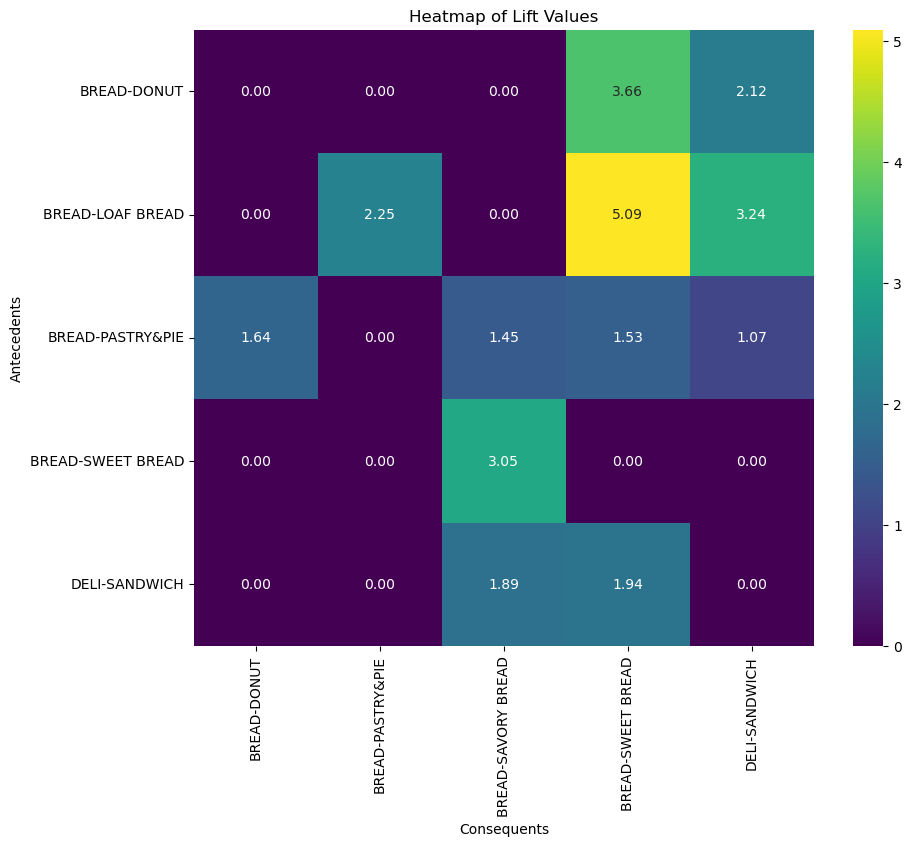

In [675]:
rules_lift = rules_cleaned
rules_lift = rules_lift[rules_lift['lift'] > 1]
print(rules_lift)


rules_lift['antecedents_str'] = rules_lift['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_lift['consequents_str'] = rules_lift['consequents'].apply(lambda x: ', '.join(list(x)))

lift_matrix = rules_lift.pivot(index='antecedents_str', columns='consequents_str', values='lift')
lift_matrix = lift_matrix.fillna(0)
lift_matrix

plt.figure(figsize=(10,8))
sns.heatmap(lift_matrix, annot=True, cmap='viridis', fmt='.2f')
plt.title('Heatmap of Lift Values')
plt.xlabel('Consequents')
plt.ylabel('Antecedents')
plt.show()

# Lift > 1 is desirable as it indicates a positive association.
# Lift between 2 and 4 indicates a strong and actionable association.
# Lift > 4 shows very strong relationships that are highly valuable for decision-making.
# Lift < 1 usually indicates a weak or negative association and might not be useful unless the goal is to find patterns to avoid

# def draw_graph(rules_cleaned, rules_to_show):
    G1 = nx.DiGraph()

    color_map = []
    N = rules_to_show

    rule_labels = [f'R{i}' for i in range(N)]

    for i in range(N):
        G1.add_nodes_from([rule_labels[i]])

        for j in rules_cleaned.iloc[i]['antecedents']:
            G1.add_nodes_from([j])
            G1.add_edge(j, rule_labels[i], color='black', weight=2)
            
        for k in rules_cleaned.iloc[i]['consequents']:
            G1.add_nodes_from([k])
            G1.add_edge(rule_labels[i], k, color='gray', weight=2)
        
    for node in G1.nodes():
        if node in rule_labels:
            color_map.append('blue')
        else:
            color_map.append('red')
    
    edges = G1.edges()
    edge_colors = [G1[u][v]['color'] for u, v in edges]
    edge_weights = [G1[u][v]['weight'] for u, v in edges]

    pos = nx.spring_layout(G1, k=16, scale=1)

    nx.draw(G1, pos, node_color = color_map, edge_color=edge_colors, width=edge_weights, font_size=16, with_labels=False)
    
    for p in pos: 
        pos[p][1] += 0.1
        
    nx.draw_networkx_labels(G1, pos)

    plt.show()



draw_graph(rules_cleaned, 4)